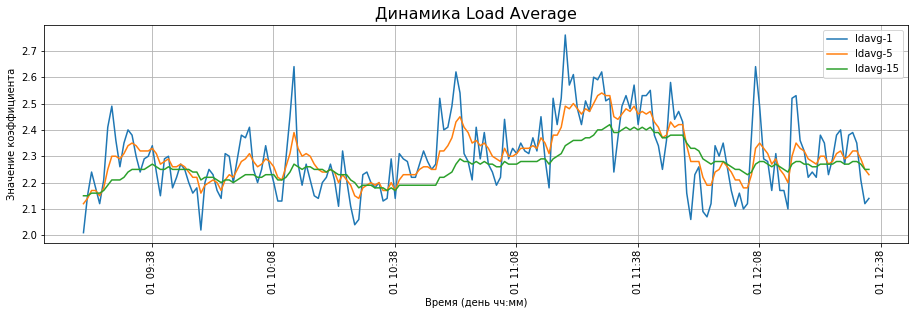

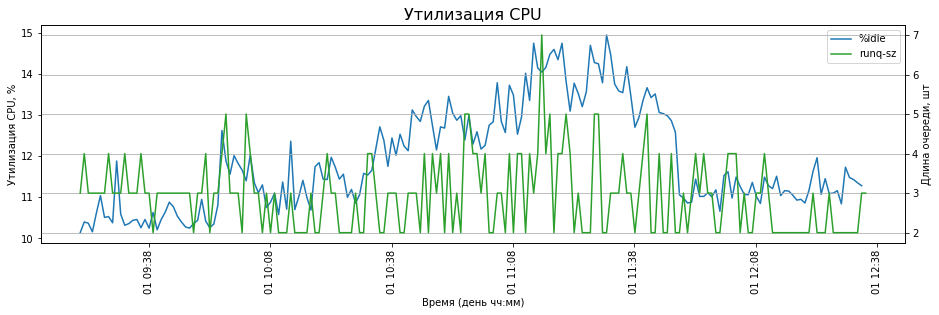

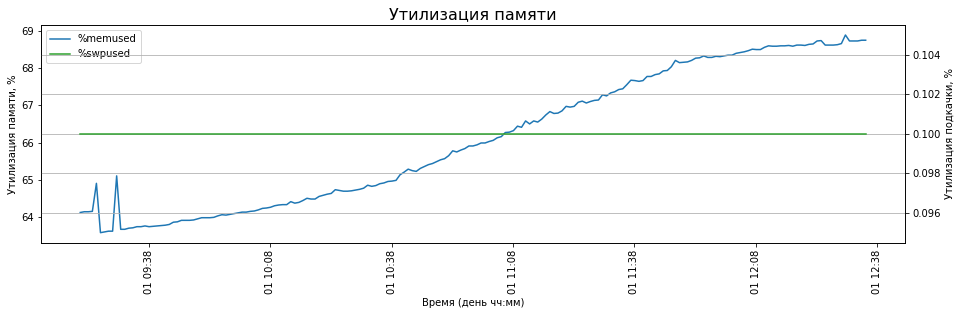

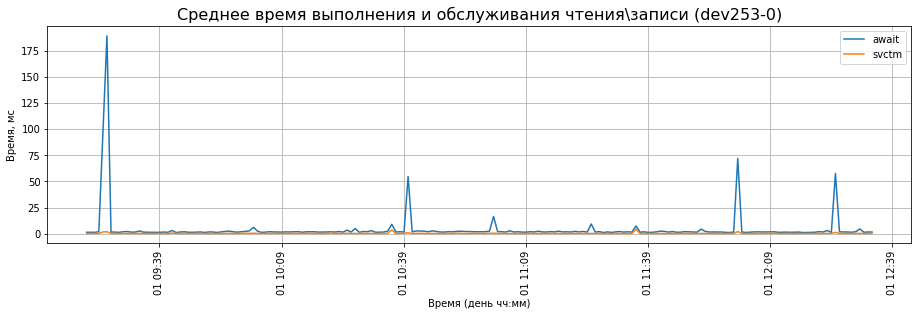

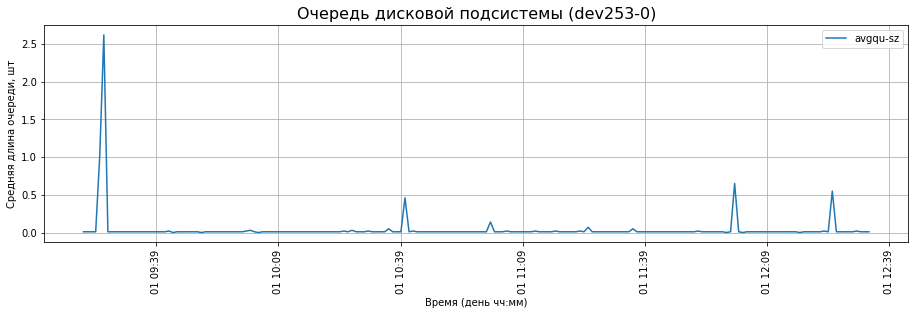

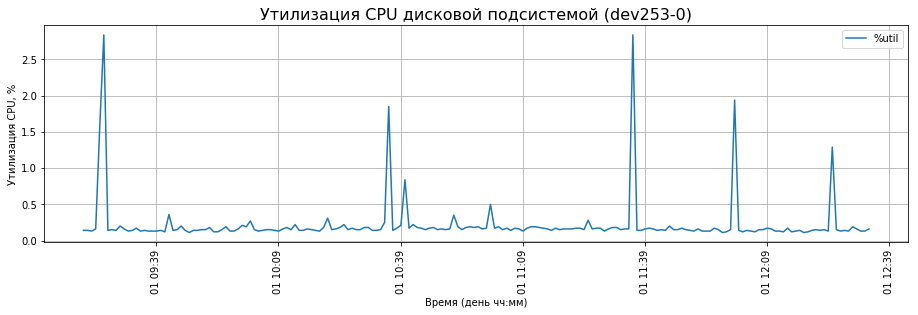

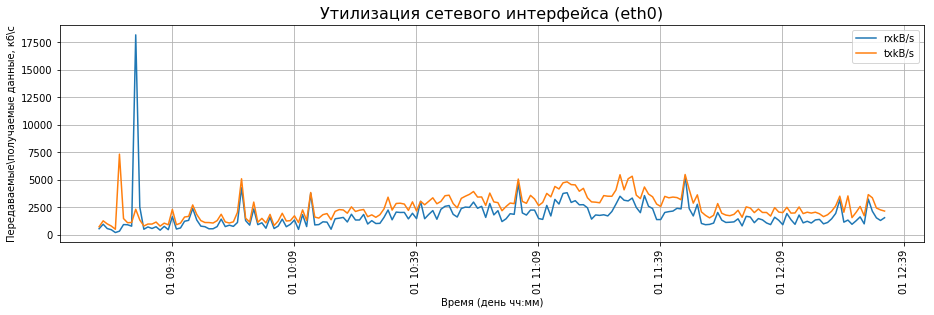

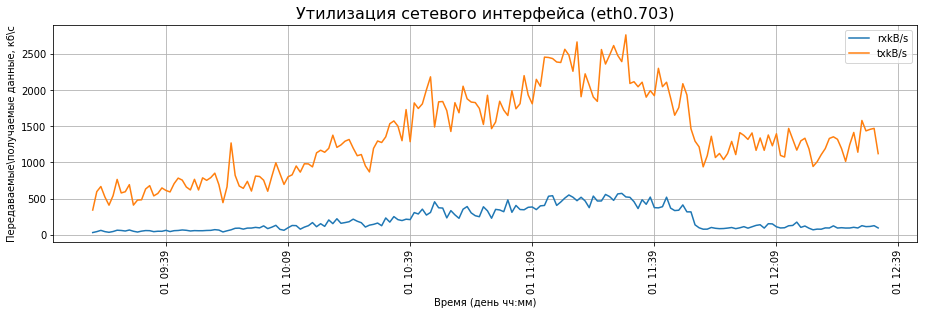

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import re

def set_graph(
    df1, df1_values, title, df1_xlabel, df1_ylabel, 
    df2 = pd.DataFrame(), df2_values = [], df2_ylabel = ''):
    
    ax2 = None
    fig,ax1 = plt.subplots()
    plt.xticks(rotation = 90, fontsize = 10)

    make_line(df1, df1_values)
    
    if df2.empty != True:
        ax2 = ax1.twinx()
        make_line(df2, df2_values, 'tab:green')

        handles, labels = ax1.get_legend_handles_labels()
        handles1, labels1 = ax2.get_legend_handles_labels()
        ax1.legend(
            handles + handles1,
            labels + labels1)
    else:  
        plt.legend() 
        
    print_labels(
        ax1, title,
        df1_xlabel, df1_ylabel,
        ax2, df2_ylabel,)
    
def make_line(df, values, color = None):
    

    values = values.split() 
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S')
    for i in range(len(values)):
        df[values[i]] = pd.to_numeric(df[values[i]])
        plt.plot(df['timestamp'], df[values[i]], label = values[i], color = color)  

def print_labels(ax1, title, xlabel, ylabel, ax2, second_ylabel = ''):

    plt.grid()
    plt.gcf().subplots_adjust(left = 1, right = 3)
    plt.title(title,fontsize = 16)
    ax1.set_ylabel(ylabel, fontsize = 10)
    ax1.set_xlabel(xlabel, fontsize = 10)
    if ax2 != None:
        ax2.set_ylabel(second_ylabel, fontsize = 10)
        
def read_file(path):
    
    try:
        f = open(path, 'r')
        log = f.readlines()
        
    except FileNotFoundError:
        print("File not found")
        
    f.close()
    
    return log


def parse(log, string = '.*'):
    
    temp = []
    
    for i in range (len(log)):
        for j in range(1,len(log[i])):     
            if re.search(string, log[i][j]) and  re.search('Average', log[i][j]) == None:
                temp.append(log[i][j].replace('\n','').split())
                
    temp.pop(len(temp)-1)
    
    return temp

    
def split_data(log):
    
    chunk = []
    all_log = []
    for i in range(len(log)):
        chunk.append(log[i])
        
        if log[i] == '\n':
            all_log.append(chunk)
            chunk = []
            
    return all_log


def rejoin(log):
    
    log = split_data(log)
    pattern = re.compile('(?<=\d\d:\d\d:\d\d).*') 
    chunk = []
    result_log = []
    
    log.pop(0)
    chunk.append(log[0])

    for i in range(len(log) - 1):

        if pattern.search(log[i][0]).group() != pattern.search(log[i + 1][0]).group():
            result_log.append(chunk)
            chunk = []

        chunk.append(log[i + 1])
    
    return result_log
    
    
    
path = '/home/winterfir/Загрузки/sar_mpgu_izh.csv'
log = read_file(path)
log = rejoin(log)


sar_q = pd.DataFrame.from_records(parse(log[10]),
columns = ['timestamp','runq-sz','plist-sz','ldavg-1','ldavg-5','ldavg-15'])

sar_C = pd.DataFrame.from_records(parse(log[0],'all'),
columns = ['timestamp','CPU','%usr','%nice','%sys','%iowait','%steal','%irq','%soft','%guest','%idle'])
sar_C['%idle'] = pd.to_numeric(sar_C['%idle'])
sar_C['%idle'] = 100 - sar_C['%idle']

sar_r = pd.DataFrame.from_records(parse(log[7]),
columns = ['timestamp','kbmemfree', 'kbmemused', '%memused', 'kbbuffers', 'kbcached', 'kbcommit', '%commit'])

sar_S = pd.DataFrame.from_records(parse(log[8]),
columns = ['timestamp','kbswpfree', 'kbswpused', '%swpused', 'kbswpcad', '%swpcad'])

sar_d = pd.DataFrame.from_records(parse(log[11], 'dev253-0'.format(i)),
columns = ['timestamp','DEV', 'tps', 'rd_sec/s', 'wr_sec/s', 'avgrq-sz', 'avgqu-sz', 'await', 'svctm', '%util'])

sar_n_DEV_eth0 = pd.DataFrame.from_records(parse(log[12], 'eth0 '),
columns = ['timestamp','IFACE', 'rxpck/s', 'txpck/s', 'rxkB/s', 'txkB/s', 'rxcmp/s', 'txcmp/s', 'rxmcst/s'])

sar_n_DEV_eth0_703 = pd.DataFrame.from_records(parse(log[12], 'eth0\.703'),
columns = ['timestamp','IFACE', 'rxpck/s', 'txpck/s', 'rxkB/s', 'txkB/s', 'rxcmp/s', 'txcmp/s', 'rxmcst/s'])


set_graph(sar_q, 'ldavg-1 ldavg-5 ldavg-15',
          'Динамика Load Average',
          'Время (день чч:мм)',
          'Значение коэффициента')

set_graph(sar_C, '%idle', 
          'Утилизация CPU',
          'Время (день чч:мм)',
          'Утилизация CPU, %', 
           sar_q, 'runq-sz',
          'Длина очереди, шт')

set_graph(sar_r, '%memused',
         'Утилизация памяти',
         'Время (день чч:мм)',
         'Утилизация памяти, %',
          sar_S, '%swpused',
         'Утилизация подкачки, %')

   
set_graph(sar_d, 'await svctm',
          'Среднее время выполнения и обслуживания чтения\записи (dev253-0)',
          'Время (день чч:мм)',
          'Время, мс')
set_graph(sar_d, 'avgqu-sz',
          'Очередь дисковой подсистемы (dev253-0)',
          'Время (день чч:мм)',
          'Средняя длина очереди, шт')
set_graph(sar_d, '%util',
          'Утилизация CPU дисковой подсистемой (dev253-0)',
          'Время (день чч:мм)',
          'Утилизация CPU, %')

set_graph(sar_n_DEV_eth0, 'rxkB/s txkB/s',
          'Утилизация сетевого интерфейса (eth0)',
          'Время (день чч:мм)',
          'Передаваемые\получаемые данные, кб\с')

set_graph(sar_n_DEV_eth0_703, 'rxkB/s txkB/s',
          'Утилизация сетевого интерфейса (eth0.703)',
          'Время (день чч:мм)',
          'Передаваемые\получаемые данные, кб\с')

plt.show()


